---
# KT, 지니랩스
---

In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import shutil
import glob # 특정 폴더에 하위 폴더 및 파일 목록을 다 가져오는 모듈
import cv2

# 경고 뜨지 않게 ..
import warnings
warnings.filterwarnings('ignore')

# 출력한 내용 청소
from IPython.display import clear_output

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['xtick.labelcolor'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['ytick.labelcolor'] = 'white'
plt.rcParams['legend.labelcolor'] = 'white'
plt.rcParams['legend.facecolor'] = 'grey'


# 랜덤 모듈
import random

# 학습 모델 저장 및 복원
import pickle

# 딥러닝 라이브러리
import tensorflow as tf
# 신경망 모델을 관리하는 객체
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 선형 회귀 레이어
from tensorflow.keras.layers import Dense
# 활성화 함수를 정의하는 객체
from tensorflow.keras.layers import Activation
# 원핫 인코딩을 수행하는 함수
from tensorflow.keras.utils import to_categorical
# 모델을 자동 저장한다.
from tensorflow.keras.callbacks import ModelCheckpoint
# 성능이 더이상 좋아지지 않을 경우 중단 시킨다.
from tensorflow.keras.callbacks import EarlyStopping
# GPU 사용 확인
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

# 사전학습 모델
from tensorflow.keras.applications import VGG16

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 표준화
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 문자열 -> 숫자
from sklearn.preprocessing import LabelEncoder

# 전체데이터를 학습용과 검증으로 나눈다.
from sklearn.model_selection import train_test_split, KFold

# ★매우 중요★
# 현재 프로젝트에서 GPU 메모리 사용을 필요한 만큼만 쓸 수 있도록 한다.
# 컴퓨터에 있는 GPU 정보들을 가져온다.
# gpu가 있다면...

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [2]:
# CNN : 커널을 통해 합성곱을 구하는 것. 이미지의 특징이 두드러 지게 한다.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D

# MaxPooling : 커널내에서 가장 큰 값을 추출하는 방식으로 불필요한 부분을 제거한다.
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import MaxPool1D

# Flatten : 다차원의 이미지 데이터를 선형 회귀 은닉층으로 전달하기 전에
# 1차원으로 변환하는 것
from tensorflow.keras.layers import Flatten

# Dropout : 이미지나 영상, 음파 등의 데이터는 오랫동안 학습을 진행 시켜야 한다.
# 하지만 너무 빨리 과적합이 발생되면 조기 중단 때문에 학습 횟수가 줄어들 수 있다.
# 이에 은닉의 노드를 일부 사용하지 않으므로써 과적합이 빨리 오는 것을 예방하고
# 오랫동한 학습이 진행될 수 있도록 한다.
from tensorflow.keras.layers import Dropout

In [3]:
# 이미지 파일을 지정하여 이미지 데이터를 읽어온다.
from PIL import Image

In [4]:
# 하위 폴더 들의 이름을 가져온다(결과 데이터)
categories = list(os.walk('./pre_trained'))[0][1]  # [0] 폴더목록, [0][1] 폴더목록 내 하위폴더

In [5]:
categories

['가자미전',
 '간장게장',
 '감자탕',
 '거봉포도',
 '고구마',
 '고구마맛탕',
 '고등어찌개',
 '곱창구이',
 '군만두',
 '굴전',
 '김치찌개',
 '깻잎나물볶음',
 '꼬리곰탕',
 '꽈리고추무침',
 '나시고랭',
 '누룽지',
 '단무지',
 '달걀말이',
 '달걀볶음밥',
 '달걀비빔밥',
 '닭가슴살',
 '닭개장',
 '닭살채소볶음',
 '닭칼국수',
 '도가니탕',
 '도토리묵',
 '돼지감자',
 '돼지고기구이',
 '두부',
 '두부고추장조림',
 '딸기',
 '떡갈비',
 '떡국',
 '레드와인',
 '마늘쫑무침',
 '마카롱',
 '매운탕',
 '미소된장국',
 '미소장국',
 '미역초무침',
 '바나나우유',
 '바지락조개국',
 '보리밥',
 '불고기',
 '비빔밥',
 '뼈해장국',
 '삼선자장면',
 '새우매운탕',
 '새우볶음밥',
 '생연어']

In [6]:
num_classes = len(categories)

In [7]:
# image size
image_w = 64
image_h = 64
channel = 3

pixels = image_w * image_h * channel

In [8]:
CLASS = 50

In [9]:
X = []
y = []

for idx, category in enumerate(categories[:CLASS]):
    # one-hot
    label = [0 for i in range(CLASS)]
    label[idx] = 1
    
    image_dir = './pre_trained/' + category
    files = glob.glob(image_dir + './*.jpg')
    print(category, "파일 길이 : ", len(files))
    
    for i, j in enumerate(files):
        img = Image.open(j)
#       img = img.convert("L")
        img = img.resize((image_w, image_h))
        data = np.asarray(img) / 255
        
        X.append(data)
        y.append(label)
        
        if i % 700 == 0 :
            print(category, ':', j)
        
X = np.array(X)
y = np.array(y)

가자미전 파일 길이 :  101
가자미전 : ./pre_trained/가자미전.\0.jpg
간장게장 파일 길이 :  101
간장게장 : ./pre_trained/간장게장.\0.jpg
감자탕 파일 길이 :  101
감자탕 : ./pre_trained/감자탕.\0.jpg
거봉포도 파일 길이 :  101
거봉포도 : ./pre_trained/거봉포도.\0.jpg
고구마 파일 길이 :  101
고구마 : ./pre_trained/고구마.\0.jpg
고구마맛탕 파일 길이 :  101
고구마맛탕 : ./pre_trained/고구마맛탕.\0.jpg
고등어찌개 파일 길이 :  101
고등어찌개 : ./pre_trained/고등어찌개.\0.jpg
곱창구이 파일 길이 :  101
곱창구이 : ./pre_trained/곱창구이.\0.jpg
군만두 파일 길이 :  101
군만두 : ./pre_trained/군만두.\0.jpg
굴전 파일 길이 :  101
굴전 : ./pre_trained/굴전.\0.jpg
김치찌개 파일 길이 :  101
김치찌개 : ./pre_trained/김치찌개.\0.jpg
깻잎나물볶음 파일 길이 :  101
깻잎나물볶음 : ./pre_trained/깻잎나물볶음.\0.jpg
꼬리곰탕 파일 길이 :  101
꼬리곰탕 : ./pre_trained/꼬리곰탕.\0.jpg
꽈리고추무침 파일 길이 :  101
꽈리고추무침 : ./pre_trained/꽈리고추무침.\0.jpg
나시고랭 파일 길이 :  101
나시고랭 : ./pre_trained/나시고랭.\0.jpg
누룽지 파일 길이 :  101
누룽지 : ./pre_trained/누룽지.\0.jpg
단무지 파일 길이 :  101
단무지 : ./pre_trained/단무지.\0.jpg
달걀말이 파일 길이 :  101
달걀말이 : ./pre_trained/달걀말이.\0.jpg
달걀볶음밥 파일 길이 :  101
달걀볶음밥 : ./pre_trained/달걀볶음밥.\0.jpg
달걀비빔밥 파일 길이 :  101
달걀비빔밥 : ./pr

In [10]:
data.shape

(64, 64, 3)

In [11]:
X.shape, y.shape

((5050, 64, 64, 3), (5050, 50))

In [12]:
from sklearn.datasets import load_iris # 샘플 데이터 로딩
from sklearn.model_selection import train_test_split

# load sample

data = X
target = y

# train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=target, random_state=34)

In [13]:
# 다중 분류 옵션들
out_nodes = CLASS
loss_function = 'categorical_crossentropy'
activation_function = 'softmax'

In [14]:
# # 신경망 설계
# model = Sequential()

# # CNN : 이미지 데이터를 입력받아 합성곱을 수행한다.
# # 첫 번째 매개변수 : 노드의 개수 = 커널의 개수
# # kernel_size : 커널 하나의 가로, 세로 길이 2*2 or 3*3 추천
# # input shape : 입력되는 이미지의 세로길이 가로길이 채널 수
# model.add(Conv2D(32, kernel_size = (3,3), input_shape = (image_h, image_w, channel), padding="same"))
# model.add(Activation('LeakyReLU'))

# model.add(Conv2D(64, kernel_size = (3,3), padding="same"))
# model.add(Activation('LeakyReLU'))
# # 과적합 방지
# model.add(Dropout(0.25))

# model.add(Conv2D(128, kernel_size = (3,3), padding="same"))
# model.add(Activation('LeakyReLU'))

# # 커널 내에서 가장 큰 값만 추출하여 불필요한 부분을 제거한다.
# model.add(MaxPool2D(pool_size = 2))



# # 다차원의 이미지 데이터를 1차원으로 변환
# model.add(Flatten())

# # CNN 층을 통해 변형된 이미지 데이터를 학습하는 선형 회귀층
# model.add(Dense(128))
# model.add(Activation('LeakyReLU'))
# model.add(Dropout(0.5))
# model.add(Dense(128))
# model.add(Activation('LeakyReLU'))

# # 출력층
# model.add(Dense(out_nodes))
# model.add(Activation(activation_function))

# VGG16 구현

model = Sequential()

model.add(Conv2D(input_shape=(image_w, image_h, channel),filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units= CLASS, activation="softmax"))

# 모델 컴파일
model.compile(loss = loss_function, optimizer = 'adam', metrics=['accuracy'])
model.summary()

In [15]:
# VGG16?

In [16]:
# # vgg16 모델 생성
# # include_top : False (입력층의 노드의 개수는 결정하지 않고, 출력층은 제거된다)
# # input_shape : 입력층의 노드를 설정해준다
# # weights : 사전 학습된 가중치를 설정해준다.
# vgg16_model = VGG16(include_top=True,
#                     weights = None,
#                     input_shape=(image_h, image_w, channel),
#                     classes = 10)

# # 학습시 사전학습 모델은 학습을 하지 않도록 설정한다.
# vgg16_model.trainable = True

# vgg16_model.summary()

In [17]:
model = Sequential() 



model.add(Flatten(input_shape= (image_h, image_w, channel)))

model.add(Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 

model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))

adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad = False)
model.compile(loss='categorical_crossentropy',
   optimizer = adam,
   metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 100)               1228900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
Total params: 1,236,500
Trainable params: 1,236,500
Non-

In [18]:
# # 신경망 설계
# model = Sequential()

# # CNN : 이미지 데이터를 입력받아 합성곱을 수행한다.
# # 첫 번째 매개변수 : 노드의 개수 = 커널의 개수
# # kernel_size : 커널 하나의 가로, 세로 길이 2*2 or 3*3 추천
# # input shape : 입력되는 이미지의 세로길이 가로길이 채널 수
# model.add(Conv2D(32, kernel_size = (3,3), input_shape = (image_h, image_w, channel)))
# model.add(Activation('LeakyReLU'))

# model.add(Conv2D(64, kernel_size = (3,3)))
# model.add(Activation('LeakyReLU'))

# model.add(MaxPool2D(pool_size = 2))

# model.add(Conv2D(128, kernel_size = (3,3)))
# model.add(Activation('LeakyReLU'))

# model.add(Conv2D(128, kernel_size = (3,3)))
# model.add(Activation('LeakyReLU'))

# model.add(Conv2D(128, kernel_size = (3,3)))
# model.add(Activation('LeakyReLU'))

# model.add(Conv2D(128, kernel_size = (3,3)))
# model.add(Activation('LeakyReLU'))

# model.add(Conv2D(128, kernel_size = (3,3)))
# model.add(Activation('LeakyReLU'))



# # 커널 내에서 가장 큰 값만 추출하여 불필요한 부분을 제거한다.
# model.add(MaxPool2D(pool_size = 2))

# # 과적합 방지

# # 다차원의 이미지 데이터를 1차원으로 변환
# model.add(Flatten())

# # CNN 층을 통해 변형된 이미지 데이터를 학습하는 선형 회귀층
# model.add(Dense(256))
# model.add(Activation('LeakyReLU'))
# model.add(Dense(128))
# model.add(Activation('LeakyReLU'))
# model.add(Dropout(0.5))
# model.add(Dense(64))
# model.add(Activation('LeakyReLU'))

# # 출력층
# model.add(Dense(out_nodes))
# model.add(Activation(activation_function))
# model.summary()

In [19]:
# vgg16_model.compile(loss = loss_function, optimizer = 'adam', metrics=['accuracy'])

In [20]:
# model.compile(loss = loss_function, optimizer = 'adam', metrics=['accuracy'])

In [21]:
# 학습모델을 저장할 경로
path = './model/zero'

```
# 만약 폴더가 있다면 삭제한다.
if os.path.isdir(path) :
    shutil.rmtree(path)
    
# 폴더를 생성한다.
os.makedirs(os.path.join(path))
```

# 모델_체크포인트 문법
path1 = path + '/{epoch}-{val_loss}.h5'
path2 = path + '/best_model.h5'

# 저장 콜백
call1 = ModelCheckpoint(filepath = path1, monitor = 'val_loss', save_best_only = True) # 이미지 작업에선 빼도된다. 용량주의
call2 = ModelCheckpoint(filepath = path2, monitor = 'val_loss', save_best_only = True)

# 조기 중단
call3 = EarlyStopping( monitor = 'val_loss', patience = 50 )

In [22]:
path2 = path + '/best_model.h5'

In [23]:
call2 = ModelCheckpoint(filepath = path2, monitor = 'val_loss', save_best_only = True)

In [24]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
        
        
    def __getitem__(self, idx):
        indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [25]:
train_loader = Dataloader(X_train, y_train, 32, shuffle=True)
valid_loader = Dataloader(X_valid, y_valid, 32, shuffle= True)

In [26]:
history = model.fit(train_loader, validation_data=valid_loader, epochs=20,validation_steps= 32,
                   callbacks= call2
                   )

Epoch 1/20
127/127 [==============================] - 7s 27ms/step - loss: 5.1380 - accuracy: 0.0416 - val_loss: 3.1955 - val_accuracy: 0.1802
Epoch 2/20
127/127 [==============================] - 2s 14ms/step - loss: 3.7119 - accuracy: 0.1205 - val_loss: 2.4058 - val_accuracy: 0.3614
Epoch 3/20
127/127 [==============================] - 2s 12ms/step - loss: 3.0102 - accuracy: 0.2114 - val_loss: 1.8077 - val_accuracy: 0.5208
Epoch 4/20
127/127 [==============================] - 2s 12ms/step - loss: 2.3968 - accuracy: 0.2963 - val_loss: 1.3120 - val_accuracy: 0.7010
Epoch 5/20
127/127 [==============================] - 2s 12ms/step - loss: 1.9357 - accuracy: 0.3948 - val_loss: 1.0382 - val_accuracy: 0.8208
Epoch 6/20
127/127 [==============================] - 2s 12ms/step - loss: 1.6741 - accuracy: 0.4522 - val_loss: 0.6185 - val_accuracy: 0.9604
Epoch 7/20
127/127 [==============================] - 2s 12ms/step - loss: 1.3335 - accuracy: 0.5502 - val_loss: 0.5254 - val_accuracy: 0.9604

In [27]:
# 리스트를 추출한다.
loss_list = history.history['loss']
accuracy_list = history.history['accuracy']
val_loss_list = history.history['val_loss']
val_accuracy_list = history.history['val_accuracy']

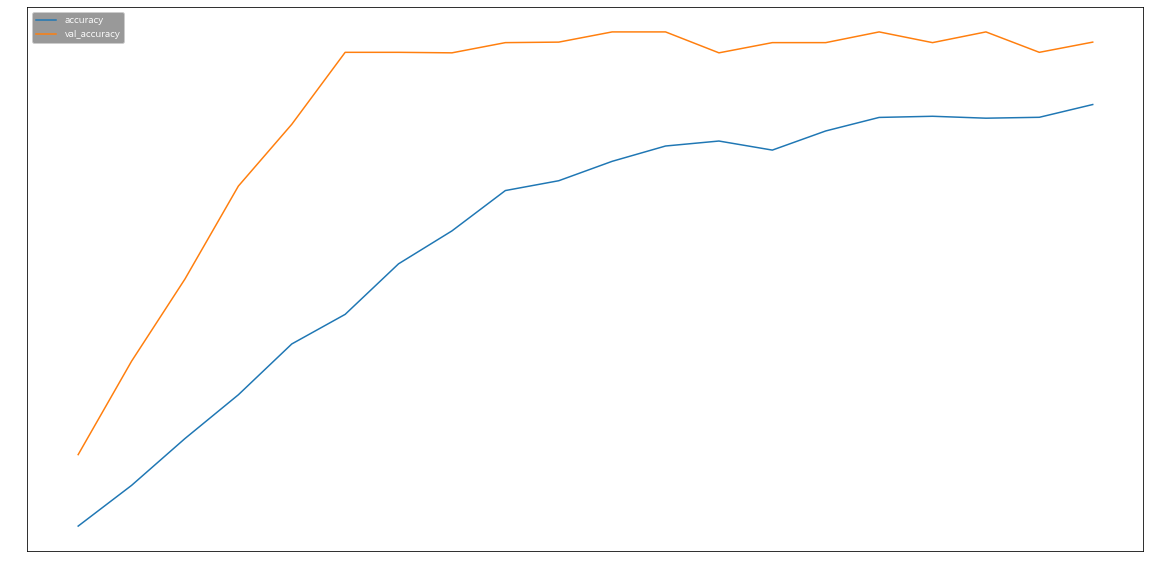

In [28]:
# 정확도 그래프
plt.plot(accuracy_list, label='accuracy')
plt.plot(val_accuracy_list, label='val_accuracy')
plt.legend()
plt.show()

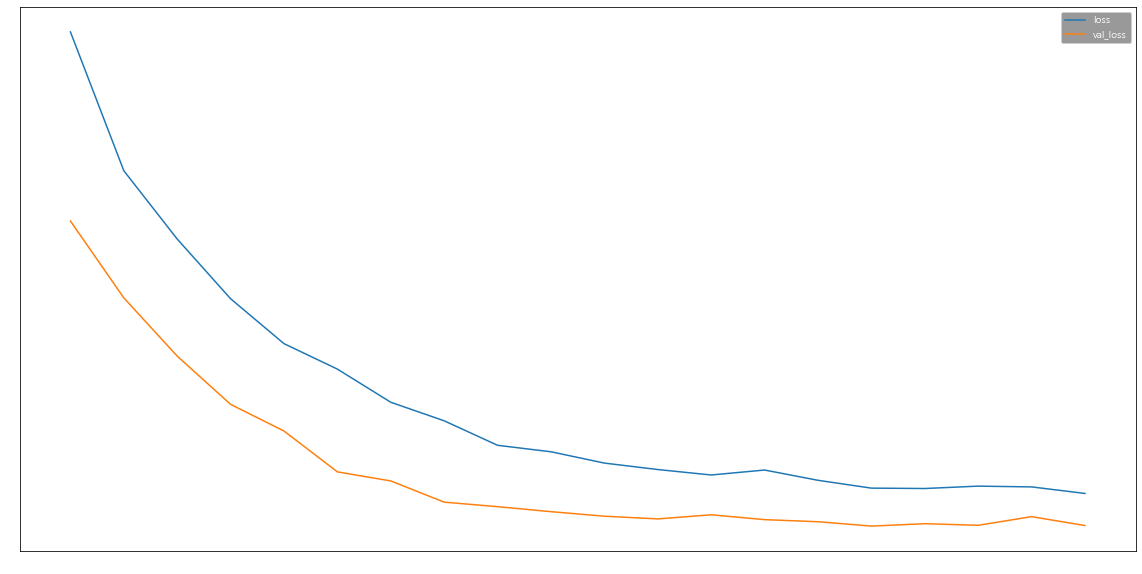

In [29]:
# 손실률
plt.plot(loss_list, label='loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()
plt.show()

# 테스트

In [30]:
# 모델불러오기
from tensorflow.keras.models import load_model
best_model = load_model('./model/zero/best_model.h5')

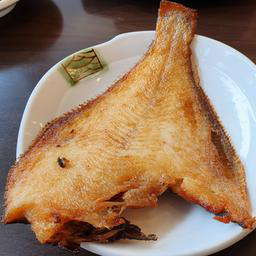

In [31]:
test_img = Image.open('./train/가자미전/07_071_07011001_160325962319321_1_1.jpg')
test_img

In [39]:
test_img = test_img.resize((64,64))

In [40]:
# test_img = test_img.resize((image_w, image_h))
# test_img

In [41]:
test_data = np.asarray(test_img) / 255

In [42]:
test_data

array([[[0.80784314, 0.77254902, 0.72156863],
        [0.80784314, 0.72156863, 0.62745098],
        [0.72941176, 0.62352941, 0.51764706],
        ...,
        [0.09019608, 0.04313725, 0.02352941],
        [0.10196078, 0.04313725, 0.01568627],
        [0.11764706, 0.05490196, 0.02352941]],

       [[0.69411765, 0.63137255, 0.56470588],
        [0.57647059, 0.49411765, 0.40784314],
        [0.45490196, 0.38431373, 0.31372549],
        ...,
        [0.12156863, 0.0627451 , 0.03921569],
        [0.14117647, 0.06666667, 0.03921569],
        [0.14901961, 0.0745098 , 0.04313725]],

       [[0.41176471, 0.34117647, 0.27843137],
        [0.42352941, 0.36470588, 0.30588235],
        [0.33333333, 0.29803922, 0.2627451 ],
        ...,
        [0.15686275, 0.07843137, 0.05098039],
        [0.17254902, 0.08235294, 0.05098039],
        [0.19215686, 0.09803922, 0.05882353]],

       ...,

       [[0.35294118, 0.34509804, 0.39607843],
        [0.34117647, 0.33333333, 0.38431373],
        [0.32941176, 0

In [43]:
test_data.shape

(64, 64, 3)

In [44]:
# 텐서로 변환
test_data = tf.reshape(test_data,(1, image_w, image_h, 3))
test_data.shape

TensorShape([1, 64, 64, 3])

In [45]:
# 예측한다.
pred = best_model.predict(test_data)
pred = pred * 255
pred.astype(int)

1/1 [==============================] - 0s 78ms/step


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 247,   0,   0,   0,   0,   0,   0,
          0,   0,   7,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [46]:
categories[-14]

'매운탕'